In [1]:
%cd ..
import clip
import torch
import argparse
from PIL import Image
from Model.ClipCap import ClipCaptionModel
from transformers import AutoTokenizer
from utils.utils import compose_discrete_prompts
from utils.load_annotations import load_entities_text
from utils.search import greedy_search, beam_search, opt_search
from utils.categories import clip_texts_embeddings, image_text_simiarlity, top_k_categories

/raid/speech/rajgothi/Project/Transformer/Project/Code


In [2]:
# name_of_entities_text = choose from this ('visual_genome_entities', 'coco_entities', 'open_image_entities', 'vinvl_vg_entities', 'vinvl_vgoi_entities'))

In [3]:
device = 'cuda:0'
clip_model = 'ViT-B/32'
language_model = 'gpt2'
continuous_prompt_length = 10
clip_project_length = 10
temperature = 0.01
top_k = 3
threshold = 0.2
disable_all_entities = False
name_of_entities_text = 'vinvl_vgoi_entities'
prompt_ensemble = True
weight_path = '../checkpoints/train_coco/coco_prefix-0014.pt'
image_path = '../images/instance1.jpg'
using_hard_prompt = True
soft_prompt_first = True
only_hard_prompt = False
using_greedy_search = False
beam_width = 5
text_prompt = None

In [4]:
clip_name = clip_model.replace('/', '') 
clip_hidden_size = 640 if 'RN' in clip_model else 512

# loading categories vocabulary for objects
if name_of_entities_text == 'visual_genome_entities':
    entities_text = load_entities_text(name_of_entities_text, '../annotations/vocabulary/all_objects_attributes_relationships.pickle', not disable_all_entities)
    if prompt_ensemble: # loading ensemble embeddings
        texts_embeddings = clip_texts_embeddings(entities_text, f'../annotations/vocabulary/visual_genome_embedding_{clip_name}_with_ensemble.pickle')
    else:
        texts_embeddings = clip_texts_embeddings(entities_text, f'../annotations/vocabulary/visual_genome_embedding_{clip_name}.pickle')
elif name_of_entities_text == 'coco_entities':
    entities_text = load_entities_text(name_of_entities_text, '../annotations/vocabulary/coco_categories.json', not disable_all_entities)
    if prompt_ensemble:
        texts_embeddings = clip_texts_embeddings(entities_text, f'../annotations/vocabulary/coco_embeddings_{clip_name}_with_ensemble.pickle')
    else:
        texts_embeddings = clip_texts_embeddings(entities_text, f'../annotations/vocabulary/coco_embeddings_{clip_name}.pickle')
elif name_of_entities_text == 'open_image_entities':
    entities_text = load_entities_text(name_of_entities_text, '../annotations/vocabulary/oidv7-class-descriptions-boxable.csv', not disable_all_entities)
    if prompt_ensemble:
        texts_embeddings = clip_texts_embeddings(entities_text, f'../annotations/vocabulary/open_image_embeddings_{clip_name}_with_ensemble.pickle')
    else:
        texts_embeddings = clip_texts_embeddings(entities_text, f'../annotations/vocabulary/open_image_embeddings_{clip_name}.pickle')
elif name_of_entities_text == 'vinvl_vg_entities':
    entities_text = load_entities_text(name_of_entities_text, '../annotations/vocabulary/VG-SGG-dicts-vgoi6-clipped.json', not disable_all_entities)
    if prompt_ensemble:
        texts_embeddings = clip_texts_embeddings(entities_text, f'../annotations/vocabulary/vg_embeddings_{clip_name}_with_ensemble.pickle')
    else:
        texts_embeddings = clip_texts_embeddings(entities_text, f'../annotations/vocabulary/vg_embeddings_{clip_name}.pickle')
elif name_of_entities_text == 'vinvl_vgoi_entities':
    entities_text = load_entities_text(name_of_entities_text, '../annotations/vocabulary/vgcocooiobjects_v1_class2ind.json', not disable_all_entities)
    if prompt_ensemble:
        texts_embeddings = clip_texts_embeddings(entities_text, f'../annotations/vocabulary/vgoi_embeddings_{clip_name}_with_ensemble.pickle')
    else:
        texts_embeddings = clip_texts_embeddings(entities_text, f'../annotations/vocabulary/vgoi_embeddings_{clip_name}.pickle')
else:
    print('The entities text should be input correctly!')
    exit()


In [5]:
tokenizer = AutoTokenizer.from_pretrained(language_model)
model = ClipCaptionModel(continuous_prompt_length, clip_project_length, clip_hidden_size, gpt_type = language_model)
model.load_state_dict(torch.load(weight_path, map_location = device), strict = False)
model.to(device)
encoder, preprocess = clip.load(clip_model, device = device)

In [6]:
def generate_caption(image_path):
    image = preprocess(Image.open(image_path)).unsqueeze(dim = 0).to(device)
    image_features = encoder.encode_image(image).float()
    image_features /= image_features.norm(2, dim = -1, keepdim = True)
    continuous_embeddings = model.mapping_network(image_features).view(-1, continuous_prompt_length, model.gpt_hidden_size)
    if using_hard_prompt:
        logits = image_text_simiarlity(texts_embeddings, temperature = temperature, images_features = image_features)
        detected_objects, _ = top_k_categories(entities_text, logits, top_k, threshold) # List[List[]], [[category1, category2, ...], [], ...]
        detected_objects = detected_objects[0] # infering single image -> List[category1, category2, ...]
        discrete_tokens = compose_discrete_prompts(tokenizer, detected_objects).unsqueeze(dim = 0).to(device)

        discrete_embeddings = model.word_embed(discrete_tokens)
        if only_hard_prompt:
            embeddings = discrete_embeddings
        elif soft_prompt_first:
            embeddings = torch.cat((continuous_embeddings, discrete_embeddings), dim = 1)
        else:
            embeddings = torch.cat((discrete_embeddings, continuous_embeddings), dim = 1)
    else:
        embeddings = continuous_embeddings
    
    if 'gpt' in language_model:
        if not using_greedy_search:
            sentence = beam_search(embeddings = embeddings, tokenizer = tokenizer, beam_width = beam_width, model = model.gpt) # List[str]
            sentence = sentence[0] # selected top 1
        else:
            sentence = greedy_search(embeddings = embeddings, tokenizer = tokenizer, model = model.gpt)
    else:
        sentence = opt_search(prompts=text_prompt, embeddings = embeddings, tokenizer = tokenizer, beam_width = beam_width, model = model.gpt)
        sentence=sentence[0]

    return sentence

In [7]:
from PIL import Image
from IPython.display import display

# Specify the path to your image file
# Open the image using PIL

def image_caption(image_path):
    img = Image.open(image_path)
    img = img.resize((512, 512))
    # Display the image
    display(img)
    print(f'the generated caption: {generate_caption(image_path)}')

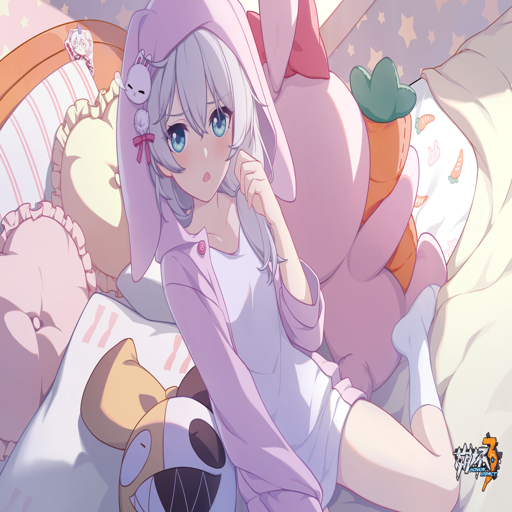

the generated caption: A little girl in pink pajamas laying on a bed.


In [8]:
image_caption(image_path)

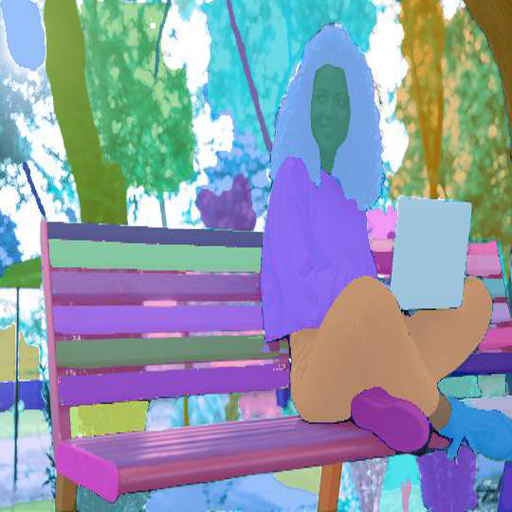

the generated caption: A teddy bear sitting on a bench in a park.


In [9]:
image_path = '../images/women-working_segmented.jpg'
image_caption(image_path)

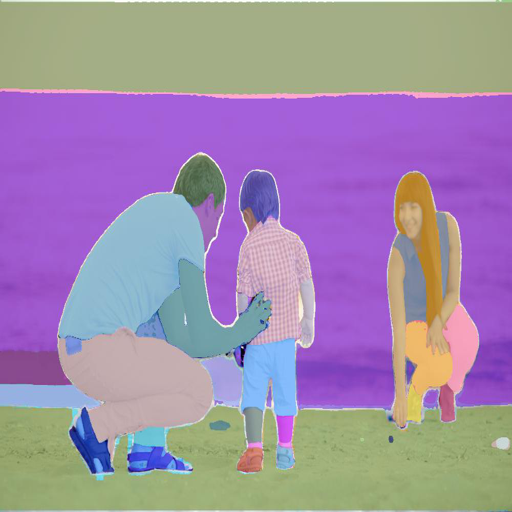

the generated caption: A man and a little girl are playing with a kite.


In [10]:
image_path = '../images/Family-at-the-beach_segmented.jpg'
image_caption(image_path)

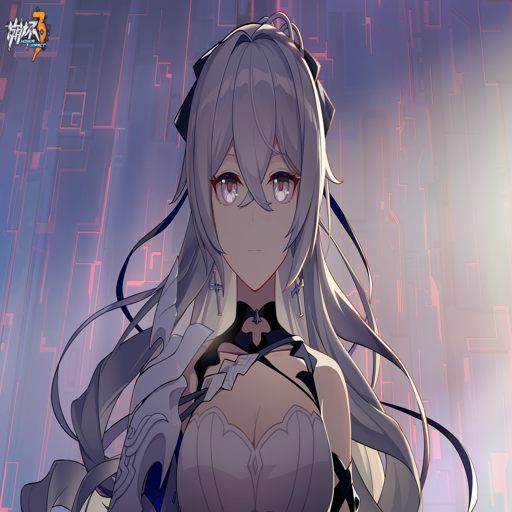

the generated caption: A woman that is standing in the dark.


In [9]:
image_path = '../images/honkai3.jpg'
image_caption(image_path)

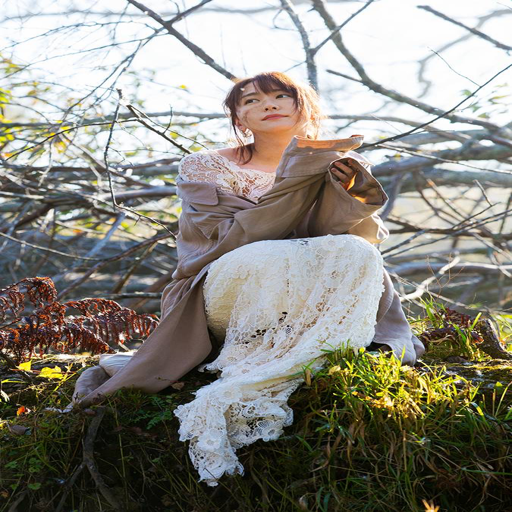

the generated caption: A beautiful woman sitting on top of a lush green field.


In [10]:
image_path = '../images/gakki1.jpg'
image_caption(image_path)

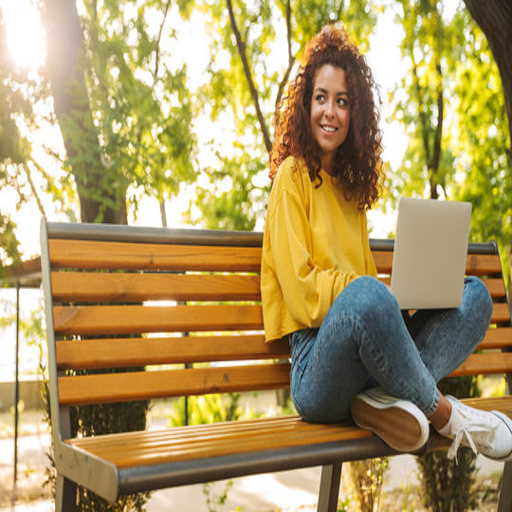

the generated caption: A woman sitting on a bench with a laptop.


In [11]:
image_path = '../images/women-working.jpg'
image_caption(image_path)